<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2024/blob/main/notebooks/es13/MetodiAI_Fis2024_Es13_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uso di OpenAI Gym e implementazione di semplici modelli RL

scopo: familiarizzare con lo sviluppo e uso di semplici modelli di reinforcment learning usando pytorch come libreria per il DL

Un sistema RL è composto da un agente (un NN nel nostro caso) e da un ambiente, che interagiscono tra loro


> environement -> assume uno stato -> observato dall' agente <p>
> agente -> esegue un azione -> influisce sul environement <p>
> environement -> assume un nuovo stato + reward -> osservato dall' agente <p>
> ...

Con i metodi di prova ed errore l'agente cerca di intraprendere azioni migliori sull'ambiente, in modo che la ricompensa totale sia massimizzata in qualche modo.

DL tools: pytorch + OpenAI Gym

### Modelli e task ###

* Actor-Critic RL applicato agli ambienti simulati: ***CartPole-V0*** e ***MountainCar-v0***

## OpenAI gym

[Gym](https://www.gymlibrary.dev): toolkit per sviluppare ambienti simulati per studi RL.

---

### CartPole-V0

Simulated env. in OpenAI gym: a pole is attached to a cart that can move to left or right directions on a binary in absence of friction. The agent have to apply a force to move the cart, and have to learn how to do that in order to prevent the pole from  falling down.

[Detailled descritpion](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

**Action space:** discrete and with dimension 2: accelerare left (0), accelerare right (1)

**Observable:** numpy 1D array of dimension 4: cart's horizontal position (0.0 == center) , velocity, tilt angle of the pole (0.0 == vertical), angular velocity of the pole.

**Reward:** 1 for each step carried on

**Initial state:** random values in [-0.05, 0.05]

**Termination of an episode:** angle >= 12 deg, abs(position) > 2.4 (0==centre), or >= 200 steps (500 for V1)

---

### MountainCar-v0

Simulated env. in OpenAI gym: a pole is attached to a cart that can move to left or right directions on a binary in absence of friction. The agent have to apply a force to move the cart, and have to learn how to do that in order to prevent the pole from  falling down.  

[Detailed description](https://gymnasium.farama.org/environments/classic_control/mountain_car/)

**Action space:** discrete with dimension 3: accelerate left (0), no acceleration (1), accelerate right (2)

**Observable:** numpy 1D array of dimension 2: car's position, velocity

**Reward:** 0 if the agent is able to bring the car up to the hill (position == 0.5), -1 if the position is < 0.5

**Initial state:** random position in [-0.6,-0.4] (note: -0.5 is the position of the minimum), v=0

**Termination of an episode:** position >= 0.5 or >= 200 steps


## Setup per visualizzare animazioni in colab


In [ ]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 x11-utils x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common xvfb
0 upgraded, 12 newly installed, 0 to remove and 45 not upgraded.
Need to get 8,045 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.

In [ ]:
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
_ = _display.start()

!echo $DISPLAY

:1005


In [ ]:
import os
import gym
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt
from IPython import display

seed = 543
torch.manual_seed(seed)

In [ ]:
# funzione utile per visualizzare il training del modello di RL
def plot_results(values, title=''):
    # Update the window after each episode
    display.clear_output(wait=True)

    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    #ax[0].set_ylim([0,200])
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')

    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

### A Dummy RL algorithm

proviamo a vedere quali saranno le performance che possiamo ottenere compiendo azioni casuali quando agiamo sul cartpole...

In [ ]:
#initialize the envioronment
env = gym.make("CartPole-v0")  # Create the environment
state = env.reset(seed=seed)

print('[pos,vel,angle,ang_vel] = ',state)

[pos,vel,angle,ang_vel] =  [-0.00352001  0.01611176 -0.00538757 -0.00544052]


In [ ]:
action = 0 #let's see what appen when we takes as action 0: i.e. accelerate left

state, reward, done, _ = env.step(action)
print('[pos,vel,angle,ang_vel] = ',state)
print('reward: ', reward)
print('done: ', done)

#as expected new position coordinate is slightly < initial position (move left), and speed
#is larger (in absolute value) and negative (left)

[pos,vel,angle,ang_vel] =  [-6.7764279e-03 -3.7397563e-01  2.1437717e-04  5.7648206e-01]
reward:  1.0
done:  False


runs for: 39 steps


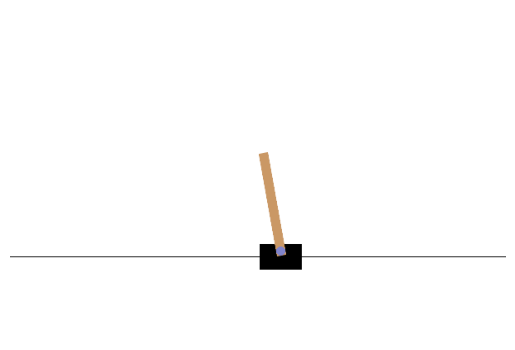

In [ ]:
# Random movement Policy

state = env.reset(seed=seed) # initialize the cart
img = plt.imshow(env.render(mode='rgb_array')) #plot the cart in the current status
done = False
i = 0
while not done:
    action = env.action_space.sample()  #.sample() takes a random sample of the action space of the env.
    img.set_data(env.render(mode='rgb_array'))
    plt.axis('off')
    display.display(plt.gcf()) #.gfc() get the current figure in plt
    display.clear_output(wait=True) #clear the previous content of the display and plot only the last one
    state, reward, done, _ = env.step(action) #apply the action
    i = i + 1
env.close()
print('runs for: %i steps' %(i))

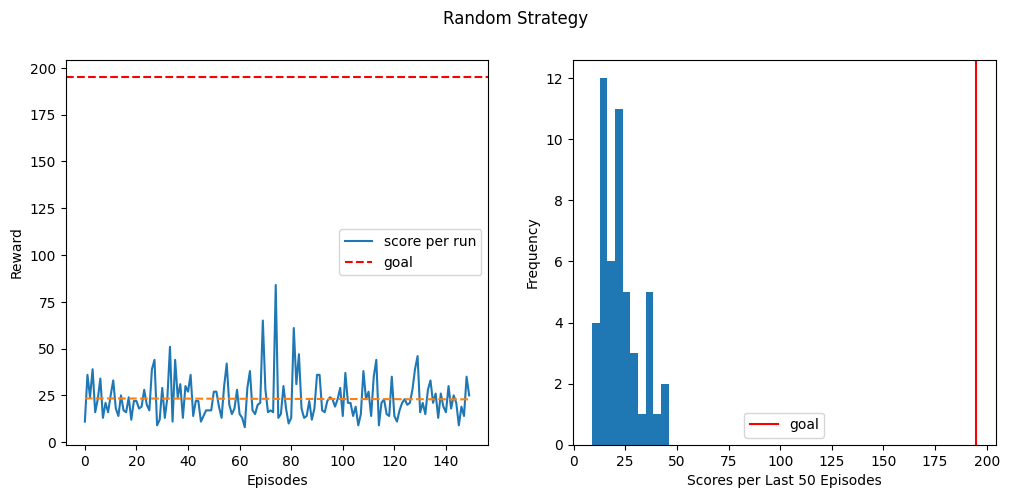

In [ ]:
# let's run 150 episodes, computing and displaying the total reward for each one to see if there are trends
# suggesting any kind of learning (we expect no as the actions are random)
episodes = 150
results = []


for episode in range(episodes):
    state = env.reset()
    done = False
    total = 0
    while not done:
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        total += reward
    results.append(total)
    plot_results(results,title='Random Strategy')
    env.close()

### A baseline RL algorithm

Proviamo ora a migliorare l'algoritmo fittizio utilizzando regole basate sul buon senso rispetto al problema specifico: ad esempio se l'asta si inclina a destra ci spostiamo a destra, e ci spostiamo a sinistra se l'asta si inclina a sinistra.

In [ ]:
env = gym.make("CartPole-v0")  # Create the environment
state = env.reset(seed=seed)

run for: 40 steps


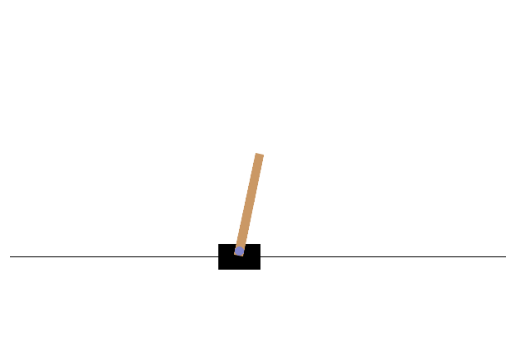

In [ ]:
# Simple Common Sense Policy
def simple_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
i = 0
while not done:
    action = simple_policy(state)
    img.set_data(env.render(mode='rgb_array'))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    i = i + 1
env.close()
print('run for: %i steps' %(i))

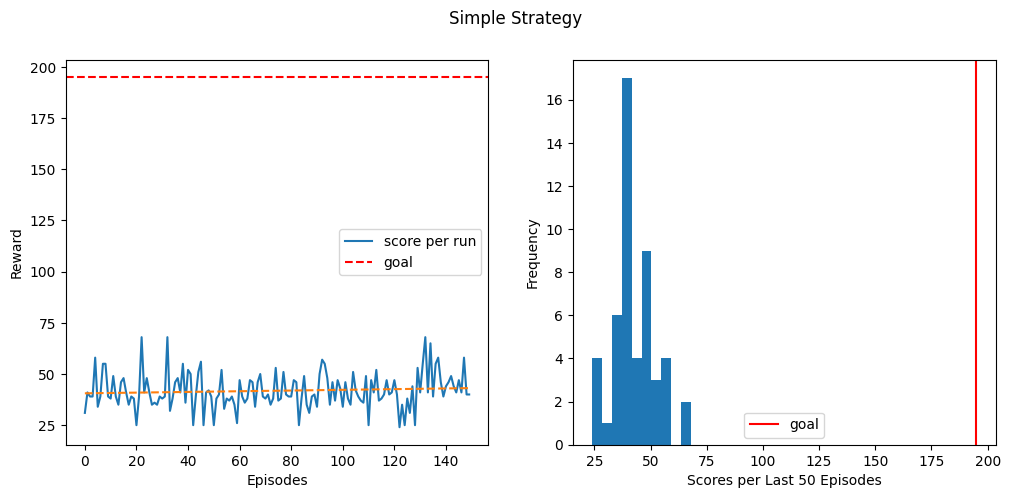

In [ ]:
# let's run 150 episodes, computing and displaying the total reward
episodes = 150
results = []

for episode in range(episodes):
    state = env.reset()
    done = False
    total = 0
    while not done:
        action = simple_policy(state)
        state, reward, done, _ = env.step(action)
        total += reward
    results.append(total)
    plot_results(results,title='Simple Strategy')
    env.close()


... un po' meglio della politica random (ricompensa ~45 rispetto a ~25) ma ancora lontana dalla soluzione del problema (mantenere in equilibrio per >=195 passi)

### Actor Critic Method

Algoritmo RL classico del tipo Policy Gradient. In questo tipo di algoritmo, cerchiamo direttamente di ottimizzare l'agente rispetto allo spazio delle policy, modellando con un DNN le probabilità associate a ciascuna azione da raccomandare.

Nell'agoritmo attore-critico (AC), l'agente è costituito da due entità separate:

* un **attore** (actor) che fornisce una rappresentazione della politica: assegna un insieme di probabilità a ogni possibile azione

* un **critico** (critic) che non è altro che una value function, cioè una funzione dello stato che stima la somma di tutte le ricompense che ci si aspetta di ricevere in futuro

Il critico apprende quanto bene l'attore (la politica) si sta comportando e utilizza queste informazioni per migliorare la politica stessa. Il miglioramento si ottiene attraverso la Gradient Policy, ovvero l'aggiornamento della politica (l'attore) al fine di massimizzare le stime della funzione di valore del critico. In altre parole l'agente viene addestrato affinché le azioni consigliate dall'attore massimizzino le future ricompense stimate dal critico.

## implementazione ANN

1. Attore: prende in input lo stato e prevede una probabilità per ogni possibile azione dello spazio d'azione
2. Critico: prende in input lo stato e prevede la ricompensa futura totale (scontata)

Questo può essere fatto con due NN separate o, poiché l'input è lo stesso, con un solo NN con un layer condiviso iniziale (useremo questo approccio perché è più pulito)


In [ ]:
seed = 543
env = gym.make("CartPole-v0")  # Create the environment
state = env.reset(seed=seed)

# Actor-Critic Model
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n
num_hidden = 256

In [ ]:
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

In [ ]:
# Actor-Critic Model

# architetture: a simple MLP one input with two outputs
class A2C(nn.Module):
  def __init__(self):
    super(A2C, self).__init__()

    self.layercondiviso = nn.Linear(4,128)
    self.attore = nn.Linear(128,2)
    self.critico = nn.Linear(128,1)


    # action & reward buffers
    self.saved_actions = []
    self.rewards = []

  def forward(self, x):
    x = F.relu(self.layercondiviso(x))
    action_prob = F.softmax(self.attore(x), dim=-1) #assign a probability to each possible action
    state_values = self.critico(x)  #predict the total discounted future reward

    return action_prob, state_values

In [ ]:
model = A2C()
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,num_inputs))
else:
  summary(model, input_size=(1,num_inputs))

A2C(
  (layercondiviso): Linear(in_features=4, out_features=128, bias=True)
  (attore): Linear(in_features=128, out_features=2, bias=True)
  (critico): Linear(in_features=128, out_features=1, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]             640
            Linear-2                 [-1, 1, 2]             258
            Linear-3                 [-1, 1, 1]             129
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
# optmizer
optimizer = optim.Adam(model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item() # return the smallest float so that: 1.0 + eps != 1.0


In [ ]:
# Parameters
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000

In [ ]:
# function to select the actions given a state
# input: numpy vector state

def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state) # given the state predict the probability of each action and the future rewards

    m = Categorical(probs) # create a categorical distribution over the list of probabilities of actions
    action = m.sample()   # sample an action using the distribution

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # the action to take (left or right)
    return action.item()

In [ ]:
# function to run an episode (computes actor and critic losses and perform bakpropagation)

def finish_episode():

    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true discounted returns values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:  #note a[::-1] retrun each element of a in revrese order (starts from the end toward the first element)
        # calculate the discounted value (using recursive formula for discounted return)
        R = r + gamma * R
        returns.insert(0, R) #insert discounted value as first element of the list

    # normalisation
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    # use advantage A2C formulation (e.g. subtract baseline )
    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss (policy gradient: log(P)*R, advantage: log(P)* (R-value estimated from critic (e.g. total discount future reward))
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss (another form of HuberLoss) (critic loss: HuberLoss(value, R))
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]

## Training

In [ ]:
# useful containers
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 10

results = []
results_rr = []


for episode_count in count(1):  # Run until solved

  state = env.reset()  #initialize the environement

  episode_reward = 0

  for timestep in range(1, max_steps_per_episode): #fill the buffer with max_steps_per_episode elements (or up to when done=True)

    # predict action
    action = select_action(state)

    # applies the new action
    state, reward, done, _ = env.step(action)

    model.rewards.append(reward)
    rewards_history.append(reward)

    episode_reward += reward

    if done:
      break

  # update the running cumulative reward
  running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

  # compute A2C and run backpropagation
  finish_episode()

  # log results
  if episode_count % 10 == 0:
    print('Episode {}\t Episode reward: {:.2f}\t Average (running) reward: {:.2f}'.format(
          episode_count, episode_reward, running_reward))

  # saves details to monitor trainign and produce useful printout
  results_rr.append(running_reward)
  results.append(episode_reward)
  #plot_results(results,title='GP Actor-Critic Strategy')

  # check if we have "solved" the cart pole problem
  if running_reward > env.spec.reward_threshold:
    print("Solved! Running reward is now {} and "
          "the last episode runs to {} time steps!".format(running_reward, timestep))
    break

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 10	 Episode reward: 11.00	 Average (running) reward: 11.96
Episode 20	 Episode reward: 12.00	 Average (running) reward: 11.69
Episode 30	 Episode reward: 11.00	 Average (running) reward: 11.58
Episode 40	 Episode reward: 19.00	 Average (running) reward: 12.47
Episode 50	 Episode reward: 146.00	 Average (running) reward: 29.83
Episode 60	 Episode reward: 78.00	 Average (running) reward: 50.84
Episode 70	 Episode reward: 62.00	 Average (running) reward: 61.98
Episode 80	 Episode reward: 79.00	 Average (running) reward: 74.93
Episode 90	 Episode reward: 93.00	 Average (running) reward: 66.26
Episode 100	 Episode reward: 133.00	 Average (running) reward: 92.46
Episode 110	 Episode reward: 200.00	 Average (running) reward: 95.95
Episode 120	 Episode reward: 200.00	 Average (running) reward: 134.32
Episode 130	 Episode reward: 73.00	 Average (running) reward: 139.04
Episode 140	 Episode reward: 13.00	 Average (running) reward: 92.85
Episode 150	 Episode reward: 28.00	 Average (runnin

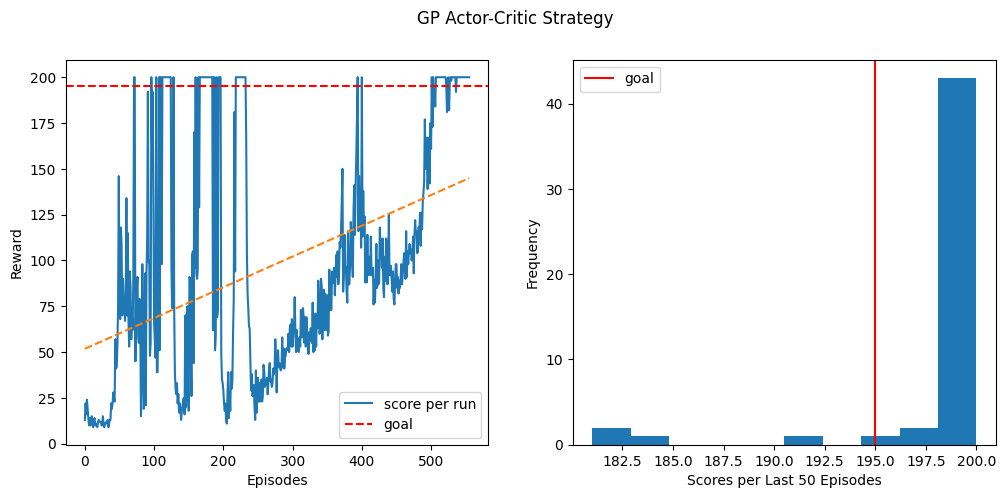

In [ ]:
#Visualize training
for episodio in range(len(results)):
  plot_results(results[:episodio],title='GP Actor-Critic Strategy')

run for: 200 steps


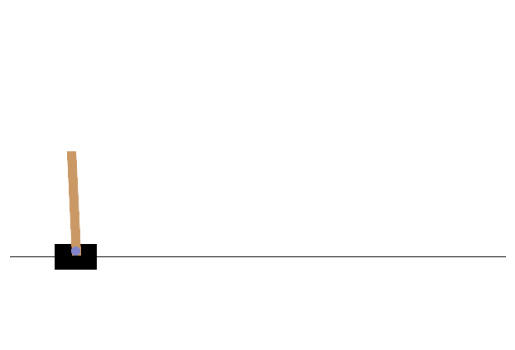

In [ ]:
# test of the trained model

model.eval()
state = env.reset(seed=seed)
img = plt.imshow(env.render(mode='rgb_array'))
done = False
i = 0
while not done:
    action = select_action(state)

    img.set_data(env.render(mode='rgb_array'))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    state, reward, done, _ = env.step(action)

    i = i + 1
env.close()
print('run for: %i steps' %(i))

### MountainCar-v0: with a baseline common sense policy

**Action space:** discrete with dimension 3: accelerate left (0), no acceleration (1), accelerate right (2)

**Observable:** numpy 1D array of dimension 2: car's position, velocity

**Reward:** 0 if the agent is able to bring the car up to the hill (position == 0.5), -1 if the position is < 0.5

**Initial state:** random position in [-0.6,-0.4] (note: -0.5 is the position of the minimum), v=0

**Termination of an episode:** position >= 0.5 or >= 200 steps

In [ ]:
seed = 543

env = gym.make("MountainCar-v0")  # Create the environment
state = env.reset(seed=seed)

print('[pos,vel] = ',state)

[pos,vel] =  [-0.50704  0.     ]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


run for: 98 steps


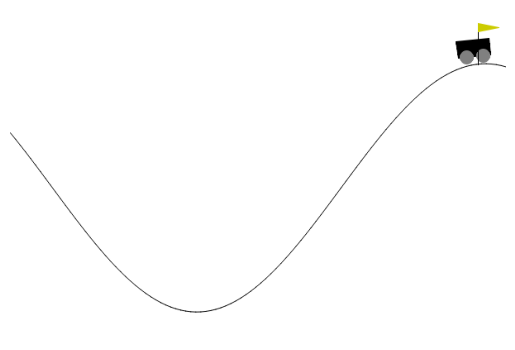

In [ ]:
# Simple common sense Policy (i.e. follows the motion direction)
def simple_policy(obs, i):
    vel = obs[1]
    pos = obs[0]+0.5 #minimum in 0
# at the first step (v=0) accelerates in downhill direction
    if i == 0:
        return 0 if pos > 0 else 2
# in the following steps accelerates in the direction in which is already moving
    return 2 if vel > 0 else 0


# select simple or random policy
random_policy = False

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
i = 0
while not done:
    if random_policy:
        action = env.action_space.sample() #random sampling of the action space
    else:
        action = simple_policy(state, i) #uses a common sense policy
    img.set_data(env.render(mode='rgb_array'))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    i = i + 1
env.close()
print('run for: %i steps' %(i))

In [ ]:
#useful function to graph the training of the RL model
def plot_results2(values, vsteps, title=''):
    # Update the window after each episode
    display.clear_output(wait=True)

    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(0.5, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    #ax[0].set_ylim([0,200])
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')

    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(0.5, c='red', label='goal')
    ax[1].set_xlabel('Scores of last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()

    tmpv0 = np.array(values)
    tmpv1 = np.array(vsteps)

    # Plot the histogram of steps
    ax[2].hist(tmpv1[tmpv0>=0.5])
    ax[2].axvline(100, c='red', label='goal')
    ax[2].set_xlabel('Steps of succesfully terminated Episodes')
    ax[2].set_ylabel('Frequency')
    ax[2].legend()
    plt.show()

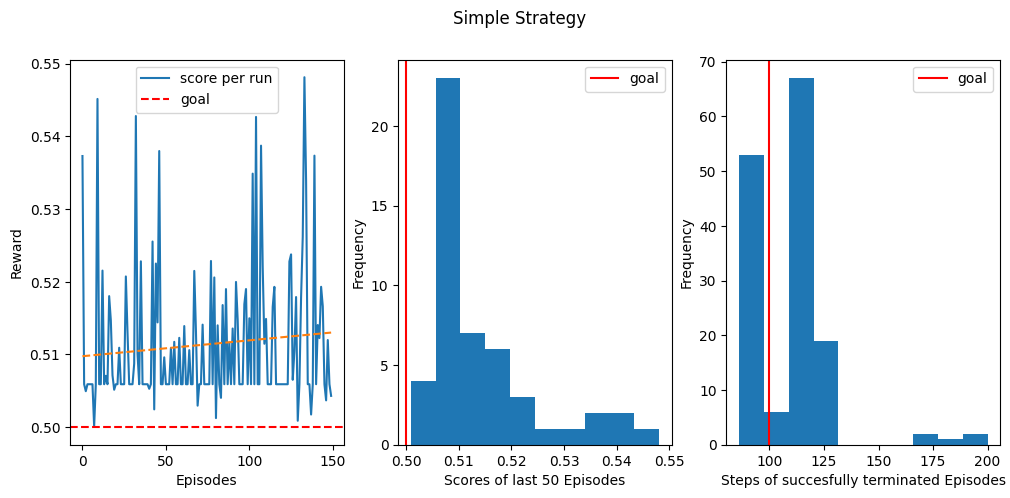

In [ ]:
# let's run 150 episodes, computing and displaying the total reward
episodes = 150
results = []
results_steps = []

beta = 1. # custom reward weight

for episode in range(episodes):
    state = env.reset()
    done = False
    total = state[0] #max climbing heights
    i = 0
    while not done:
        action = simple_policy(state, i)
        state, reward, done, _ = env.step(action)
        # custom reward:
        # the standard reward is -1 for each step and 0 when arrives to the top
        # to takes into account that untill the cart doesn't reach 0.5 (uphill) there is no positive reward, we can
        # add something proportional to the max position reached by the cart, e.g. an extra reward proportional
        # to how much the cart has been able to climb up to the hill
        # NOTE: cart maximum climbing height = np.sin(3*position)*.45 + .55
        reward_climb = 0.0
        if state[0] >= -0.4: #i.e. to the right of the minimum
          reward_climb = np.sin(3 * state[0])*.45+.55

        reward = reward + beta*reward_climb #to be used in the RL algorithm (if reach the top: reward_climb = 1 --> reward = -1 + 1 = 0.0)

        if state[0]>total:
          total = state[0]
        i = i + 1
    results.append(total)
    results_steps.append(i)
    plot_results2(results,results_steps, title='Simple Strategy')
    env.close()

# Idee per seprimentare con il modello ...

1. sperimentare il metodo A2C, modificando i parametri dei modelli e il setup del training RL
2. implementare A2C per *MountainCar-v0* env.
3. si può provare a semplificare il modello A2C, tornando a un semplice metodo Reinforce senza vantaggio (ad esempio senza critico) per verificare quanto è influenzata la velocità di convergenza
3. provare a implementare un problema con uno spazio di azione continuo (ad esempio *MountainCarContinuous-v0*)
4. prova ad applicare ciò che hai imparato a un problema più complesso, uno degli altri environment disponibili o uno dei giochi ATARI (questo è tecnicamente più complicato, se lo si vuole fare farlo magari durante l'estate come passatempo (NOTA: passare il tempo a fare cose da nerd durante l'estate non è tuttavia consigliato)).